# Vehicle Detection
---
### Imports

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import os
import pickle

from scipy.ndimage.measurements import label
from mpl_toolkits.mplot3d import Axes3D

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

%matplotlib inline

### Visualize a Car and a Not-car

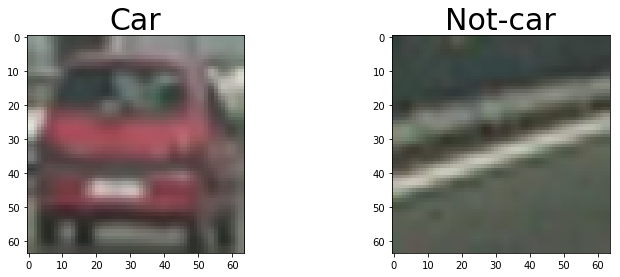

In [3]:
# Visualize Car and None-car
car_image = mpimg.imread("test_images/car_test.png")
notcar_image = mpimg.imread("test_images/notcar_test.png")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.imshow(car_image)
ax1.set_title('Car', fontsize=30)
ax2.imshow(notcar_image)
ax2.set_title('Not-car', fontsize=30)

### Spatial bin color features

In [4]:
# A function to compute spatial bin color features
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

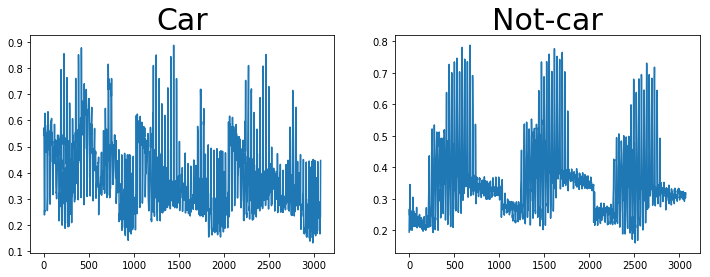

In [5]:
# Visualize Car and None-car spatial binning
bs_car = bin_spatial(car_image)
bs_notcar = bin_spatial(notcar_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(bs_car)
ax1.set_title('Car', fontsize=30)
ax2.plot(bs_notcar)
ax2.set_title('Not-car', fontsize=30)

### color histogram features

In [6]:
# A function to compute color histogram features       
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

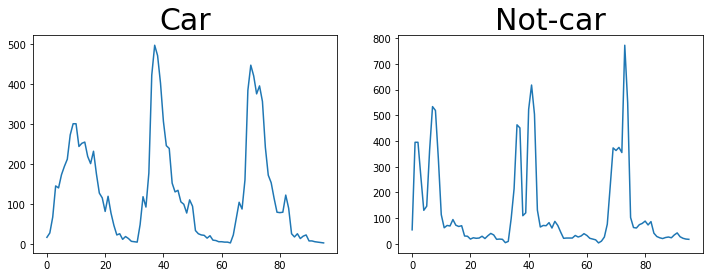

In [7]:
# Visualize Car and None-car color histogram
ch_car = color_hist(car_image)
ch_notcar = color_hist(notcar_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(ch_car)
ax1.set_title('Car', fontsize=30)
ax2.plot(ch_notcar)
ax2.set_title('Not-car', fontsize=30)

### Histogram of Oriented Gradients (HOG) features

In [8]:
# A function to Perform a Histogram of Oriented Gradients (HOG) features
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

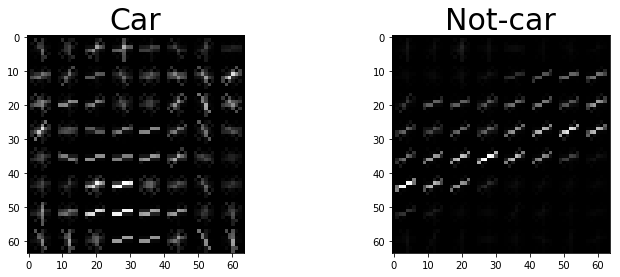

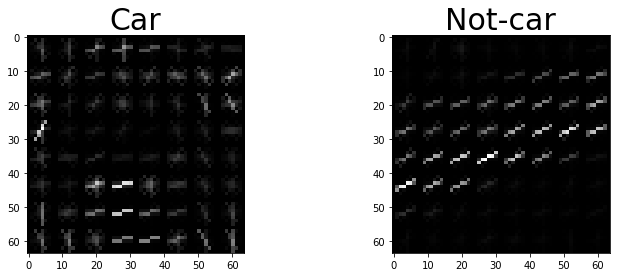

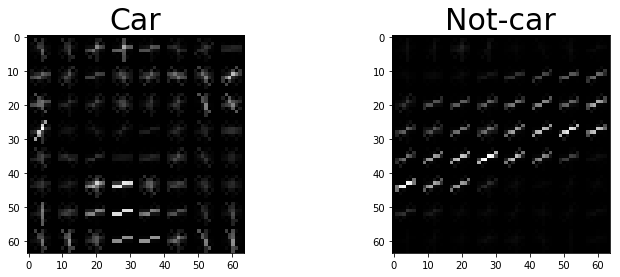

In [9]:
# Visualize Car and None-car Hog
for channel in range(car_image.shape[2]):
    _,hog_car = get_hog_features(car_image[:,:,channel], vis=True)
    _,hog_notcar = get_hog_features(notcar_image[:,:,channel], vis=True)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1.imshow(hog_car, cmap='gray')
    ax1.set_title('Car', fontsize=30)
    ax2.imshow(hog_notcar, cmap='gray')
    ax2.set_title('Not-car', fontsize=30)

### Color conversion

In [10]:
# A function to apply different color conversions
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)


### Color space comparison

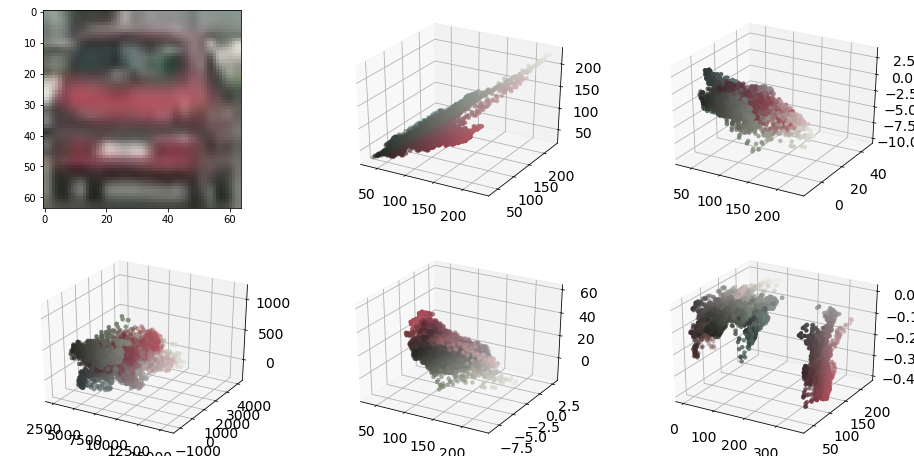

In [11]:
def plot3d(pixels, colors_rgb, ax, 
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

#     # Create figure and 3D axes
#     
#     ax = Axes3D(fig)

    # Set axis limits
#     ax.set_xlim(*axis_limits[0])
#     ax.set_ylim(*axis_limits[1])
#     ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
#     ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
#     ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
#     ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

fig = plt.figure(figsize=(16, 8))

draw_car_image = np.copy(car_image)*255

scale = max(draw_car_image.shape[0], draw_car_image.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(draw_car_image, (np.int(draw_car_image.shape[1] / scale), np.int(draw_car_image.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = img_small  # OpenCV uses BGR, matplotlib likes RGB
img_small_YCC = convert_color(img_small)
img_small_LUV = convert_color(img_small,'RGB2LUV')
img_small_YUV = convert_color(img_small,'RGB2YUV')
img_small_HLS = convert_color(img_small,'RGB2HLS')

img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

ax1  = fig.add_subplot(231)
ax1.imshow(img_small_rgb)

# Plot and show
ax2  = fig.add_subplot(232, projection='3d')
plot3d(img_small_RGB, img_small_rgb, ax2)

ax3  = fig.add_subplot(233, projection='3d')
plot3d(img_small_YCC, img_small_rgb, ax3)

ax4  = fig.add_subplot(234, projection='3d')
plot3d(img_small_LUV, img_small_rgb, ax4)

ax5  = fig.add_subplot(235, projection='3d')
plot3d(img_small_YUV, img_small_rgb, ax5)

ax6  = fig.add_subplot(236, projection='3d')
plot3d(img_small_HLS, img_small_rgb, ax6)

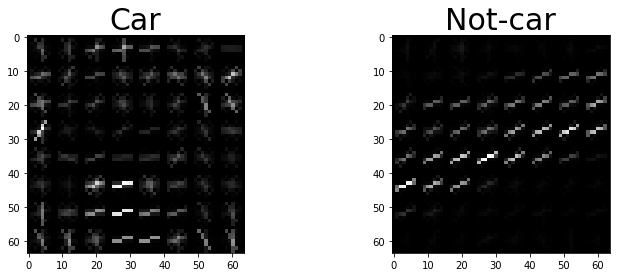

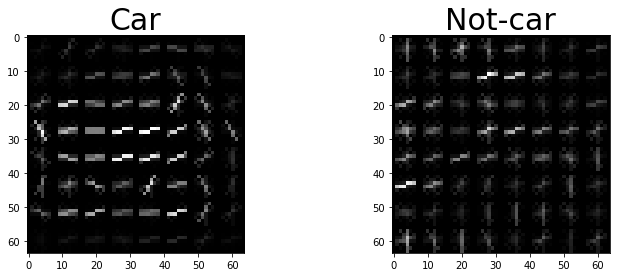

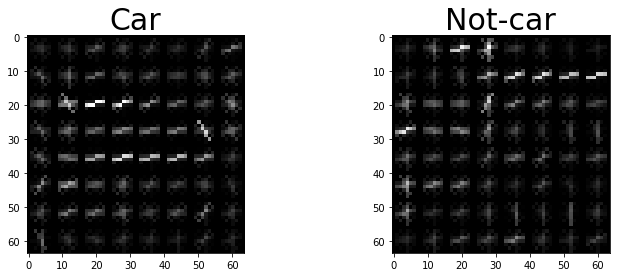

In [12]:
# Visualize Car and None-car Hog for a different color space
YCC_car_image = convert_color(car_image)
YCC_notcar_image = convert_color(notcar_image)
for channel in range(YCC_car_image.shape[2]):
    _,Yhog_car = get_hog_features(YCC_car_image[:,:,channel], vis=True)
    _,Yhog_notcar = get_hog_features(YCC_notcar_image[:,:,channel], vis=True)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1.imshow(Yhog_car, cmap='gray')
    ax1.set_title('Car', fontsize=30)
    ax2.imshow(Yhog_notcar, cmap='gray')
    ax2.set_title('Not-car', fontsize=30)

### Feature extraction on list of images

In [13]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = convert_color(image, conv='RGB2'+color_space)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Single image feature extraction

In [14]:
# A function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        feature_image = convert_color(img, conv='RGB2'+color_space)
    else: feature_image = np.copy(img)
        
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features).reshape(1,-1)

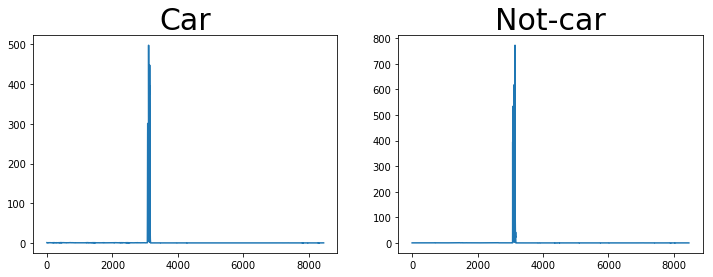

In [15]:
# Visualize Car and None-car all features (not scaled)
f_car = single_img_features(car_image, hog_channel='ALL')
f_notcar = single_img_features(notcar_image, hog_channel='ALL')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(f_car[0])
ax1.set_title('Car', fontsize=30)
ax2.plot(f_notcar[0])
ax2.set_title('Not-car', fontsize=30)

### Loading training data

In [16]:
def load_data(color_space = 'RGB', orient=9, pix_per_cell=8, cell_per_block=2,\
              hog_channel=0, spatial_size=(32, 32), hist_bins=32, spatial_feat = True, hist_feat = True, hog_feat = True):
    
    cur_path = os.getcwd()
    veh_path = os.path.join(cur_path, 'vehicles')
    nonveh_path = os.path.join(cur_path, 'non-vehicles')

    cars = [os.path.join(root, name) for root, dirs, files in os.walk(veh_path) for name in files]
    notcars = [os.path.join(root, name) for root, dirs, files in os.walk(nonveh_path) for name in files]
    
    
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X[0]))
    return X, y  

### Normalize features and split train and test

In [17]:
# A function to normalize over input features and randomize a split training and test data
def normalize_and_split(X, y, split_ratio = 0.2):
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=split_ratio, random_state=rand_state)
    
    return X_train, X_test, y_train, y_test, X_scaler

### Train a linear SVM Classifier

In [18]:
# Train classifier
def train_classifier(X_train, y_train, X_test, y_test):
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    return svc

### Save and Load the classifier

In [19]:
# Save and Load the classifier
dist_file = "svc_pickle.p"

if os.path.exists(dist_file):
    dist_pickle = pickle.load(open(dist_file,"rb"))
    svc = dist_pickle["svc"]
    color_space = dist_pickle["color_space"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    hog_channel = dist_pickle["hog_channel"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    ystart = dist_pickle["ystart"] 
    ystop = dist_pickle["ystop"]
    scale = dist_pickle["scale"]
    print("Classifier loaded!")
    
else:
    ### Feature extraction parameters
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    ystart = 400
    ystop = 656
    scale = 1.5
    
    dist_pickle = {}
    X, y = load_data(color_space = color_space, orient=orient, pix_per_cell=pix_per_cell,\
                     cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_size=spatial_size,\
                     hist_bins=hist_bins, spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
    
    X_train, X_test, y_train, y_test, X_scaler = normalize_and_split(X,y)
    svc = train_classifier(X_train, y_train, X_test, y_test)
    dist_pickle["scaler"] = X_scaler
    dist_pickle["svc"] = svc
    dist_pickle["color_space"] = color_space
    dist_pickle["orient"] = orient
    dist_pickle["pix_per_cell"] = pix_per_cell
    dist_pickle["cell_per_block"] = cell_per_block
    dist_pickle["hog_channel"] = hog_channel
    dist_pickle["spatial_size"] = spatial_size
    dist_pickle["hist_bins"] = hist_bins
    dist_pickle["ystart"] = ystart
    dist_pickle["ystop"] = ystop
    dist_pickle["scale"] = scale
    pickle.dump( dist_pickle, open( dist_file, "wb" ) )
    print("Classifier created successfully!")

Classifier loaded!


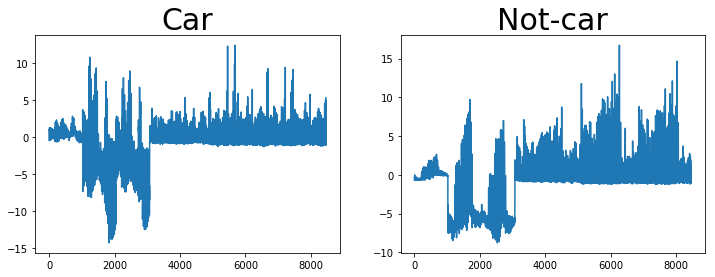

In [20]:
# Visualize Car and None-car all features

scaled_f_car = X_scaler.transform(f_car)
scaled_f_notcar = X_scaler.transform(f_notcar)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(scaled_f_car[0])
ax1.set_title('Car', fontsize=30)
ax2.plot(scaled_f_notcar[0])
ax2.set_title('Not-car', fontsize=30)

### Check the classifier output

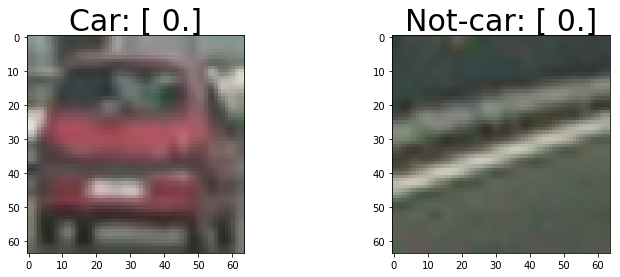

In [21]:
# Check the prediction for a single sample

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.imshow(car_image)
ax1.set_title('Car: '+str(svc.predict(scaled_f_car)), fontsize=30)
ax2.imshow(notcar_image)
ax2.set_title('Not-car: '+str(svc.predict(scaled_f_notcar)), fontsize=30)


###  A sliding-window technique to search for vehicles in images and use the trained classifier to detect vehicles

In [63]:
# A single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, svc, X_scaler, color_space = 'YCrCb', ystart = 400, ystop = 656, scale = 1.5, orient=9,\
              pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32):
    
    draw_img = np.copy(img)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if color_space != 'RGB':
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2'+color_space)
    else:
        ctrans_tosearch = img_tosearch
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    
   # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    #nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Create an empty list to receive positive detection windows
    box_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[int(ypos):int(ypos+nblocks_per_window), int(xpos):int(xpos+nblocks_per_window)].ravel() 
            hog_feat2 = hog2[ypos:int(ypos+nblocks_per_window), xpos:int(xpos+nblocks_per_window)].ravel() 
            hog_feat3 = hog3[ypos:int(ypos+nblocks_per_window), xpos:int(xpos+nblocks_per_window)].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            
            if (test_prediction == 1):
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                box_list.append(box)
        
    return box_list, draw_img

### Visualize the sliding window results

True

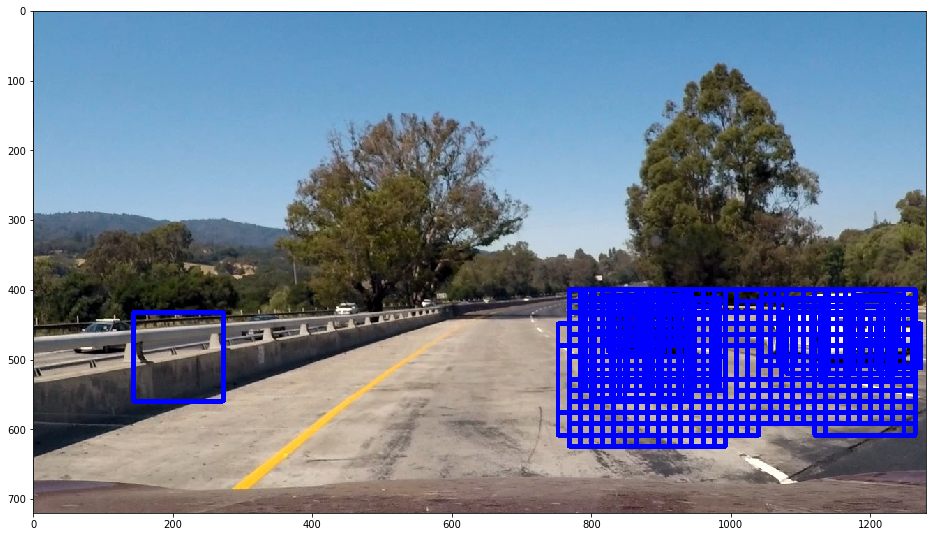

In [76]:
img = mpimg.imread('test_images/test1.jpg')
out_img = np.copy(img)
# Three different scale to find small to Big cars in the image
scales = [1, 1.5, 2]
for scale in scales:
    box_list, out_img = find_cars(out_img, svc, X_scaler, color_space = color_space, ystart = ystart,
                         ystop = ystop, scale = scale, orient=orient, pix_per_cell=pix_per_cell,
                         cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins)

plt.figure(figsize=(16,16))
plt.imshow(out_img)
tmp = cv2.cvtColor(out_img,cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/car_boxes_3scales_test1.jpg',tmp)

### Create a heatmap of found boxes to eliminate multiple detections and false positives

In [40]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
   

### Threshold the heatmap to remove false positives

In [41]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

### Draw the final labels on the image

In [42]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Find car pipeline with history (previous frame final boxes are used in the heatmap to guide the heatmap)

In [65]:
def find_cars_pipeline(img, threshold = 2, heatmap_vis = False):
    
    #using 3 scales to find cars
    scales = [1.0, 1.5, 2.0]
    for scale in scales:
        box_list,out_img = find_cars(img, svc, X_scaler, color_space = color_space, ystart = ystart,\
                     ystop = ystop, scale = scale, orient=orient, pix_per_cell=pix_per_cell,\
                     cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins)
    
        # Add heat to each box in box list
        find_cars_pipeline.heat = add_heat(find_cars_pipeline.heat,box_list)

    # Apply threshold to help remove false positives
    find_cars_pipeline.heat = apply_threshold(find_cars_pipeline.heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(find_cars_pipeline.heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    # Guide the next detection
    find_cars_pipeline.heat = np.zeros_like(img[:,:,0]).astype(np.float)
    find_cars_pipeline.heat[labels[0].nonzero()] = 1
    if heatmap_vis:
        return draw_img, heatmap, labels[0]
    else:
        return draw_img
       

### Visualize the heatmap and final labels

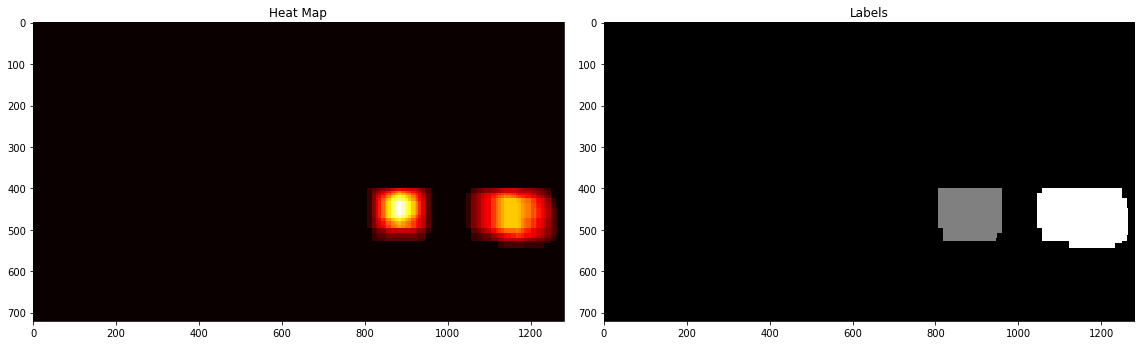

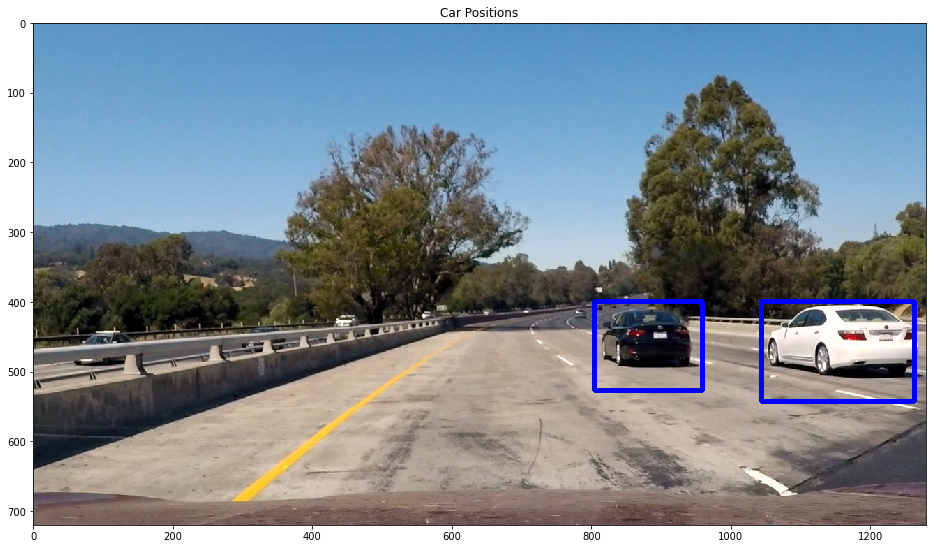

In [85]:
img = mpimg.imread('test_images/test1.jpg')

find_cars_pipeline.heat = np.zeros_like(img[:,:,0]).astype(np.float)
d_img, heatmap, lbls = find_cars_pipeline(img, threshold = 2, heatmap_vis=True)

fig = plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(122)
plt.imshow(lbls,cmap='gray')
plt.title('Labels')
fig.tight_layout()
fig = plt.figure(figsize=(16,16))
plt.imshow(d_img)
plt.title('Car Positions')
tmp = cv2.cvtColor(d_img,cv2.COLOR_RGB2BGR)
# cv2.imwrite('output_images/test6.jpg',tmp)

### Use pipeline for the test video

In [88]:
find_cars_pipeline.heat = np.zeros_like(img[:,:,0]).astype(np.float)
test_output = 'test_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
test_clip = clip1.fl_image(find_cars_pipeline) #NOTE: this function expects color images!!
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


 97%|█████████▋| 38/39 [01:55<00:02,  2.97s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 

CPU times: user 2min 12s, sys: 188 ms, total: 2min 12s
Wall time: 1min 56s


In [89]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

### Project video

In [90]:
find_cars_pipeline.heat = np.zeros_like(img[:,:,0]).astype(np.float)

project_output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(find_cars_pipeline) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [1:03:29<00:02,  2.98s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 1h 11min 47s, sys: 4 s, total: 1h 11min 51s
Wall time: 1h 3min 30s


In [91]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))